In [1]:
%load_ext autoreload
%autoreload 2
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import yaml
import numpy as np
import os
from tqdm import tqdm
from load import read_data, read_cam
tqdm.get_lock().locks = []
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

In [2]:
# decleare data parameters
# out 00 -> without bln, 0.004
par_train = {'data_dir'   : '/data/LiftPose3D/capture', # change the path 
       'out_dir'          : '/data/LiftPose3D/capture/out_across_animals',
       'train_session_id' : [1],#,2,3],
       'test_session_id'  : [0],
       'test_cam_id'      : [0]}#,1,2,3,4,5]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

#meta = mat73.loadmat('nolj_Recording_day8_caff1_nolj_imputed.mat')
# naming scheme used in the capture dataset for different cameras
cam_list = ['R', 'L', 'E', 'U', 'S', 'U2']

bone_length = {(0, 3): 80.98554459477106,
                 (3, 5): 112.90207543313412,
                 (5, 8): 28.733636975647393,
                 (5, 9): 34.84953102842617,
                 (10, 11): 15.956945352305892,
                 (3, 12): 29.946991312076776,
                 (3, 13): 19.409450872458986,
                 (10, 12): 40.857306953944935,
                 (13, 14): 37.08634981412786,
                 (14, 15): 20.954239695086592,
                 (8, 17): 35.39218881579121,
                 (9, 16): 25.59466626887338,
                 (17, 18): 31.033650232299784,
                 (16, 19): 25.244471236727712}

In [3]:
import scipy.io
from liftpose.vision_3d import normalize_bone_length, calculate_bone_length, world_to_camera, project_to_camera

train_session_id = par_train["train_session_id"]
test_session_id = par_train["test_session_id"]
test_cam_id = par_train["test_cam_id"]

train_2d, train_3d, test_2d, test_3d = list(), list(), list(), list()
#train_ind, test_ind = np.zeros((54000), dtype=bool), np.zeros((54000), dtype=bool)
#train_ind[2000:] = True
#test_ind[:2000] = True

train_keypoints = list()
test_keypoints = list()
session_id_list = par_train["train_session_id"] + par_train["test_session_id"]
cams = {'R': [], 'tvec': [], 'intr': []}
for session_id in session_id_list:
    mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
    for cam_id in test_cam_id:
        c = read_cam(session_id, cam_id)

        #pts2d = mat[cam_id]['data_2d'].reshape(-1, 20, 2)
        pts3d = mat[cam_id]['data_3d'].reshape(-1, 20, 3)
        pts3d[:,[1,2,4,6,7],:] = np.nan
        pts3d_tmp = world_to_camera(pts3d.copy(), c['r'].T, c['t'])
        pts2d = project_to_camera(pts3d_tmp, c['K'].T)
        # bone length normalization
        #pts3d = normalize_bone_length(pts3d.copy(), root=par["roots"][0], child=par_data["vis"]["child"], bone_length=bone_length, thr=10)
        
        cams['R'].append(c['r'].T)
        cams['tvec'].append(c['t'])
        cams['intr'].append(c['K'].T)

        if session_id in train_session_id:
            #train_2d.append(pts2d[train_ind])
            #train_3d.append(pts3d[train_ind])
            train_2d.append(pts2d)
            train_3d.append(pts3d)

        if session_id in test_session_id:
            #test_3d.append(pts3d[test_ind])
            #test_2d.append(pts2d[test_ind])
            test_3d.append(pts3d)
            test_2d.append(pts2d)
            
train_2d = np.concatenate(train_2d, axis=0)
train_3d = np.concatenate(train_3d, axis=0)
test_2d = np.concatenate(test_2d, axis=0)
test_3d = np.concatenate(test_3d, axis=0)
train_keypoints = np.logical_not(np.isnan(train_3d))
test_keypoints = np.logical_not(np.isnan(test_3d))

# if more than one third is missing remove it
train_keypoints[np.sum(np.logical_not(train_keypoints), axis=(1,2)) > 20] = False
test_keypoints[np.sum(np.logical_not(test_keypoints), axis=(1,2)) > 20] = False

# if the root is none, then ignore that point, otherwise we cannot anchor
train_keypoints[np.any(np.isnan(train_2d[:,3]),axis=-1)] = False
test_keypoints[np.any(np.isnan(test_2d[:,3]),axis=-1)] = False

# impute nan's with zeros. zero 3d points will not be counted towards loss.
#train_2d[np.isnan(train_2d)] = 0
#train_3d[np.isnan(train_3d)] = 0
#test_2d[np.isnan(test_2d)] = 0
#test_3d[np.isnan(test_3d)] = 0

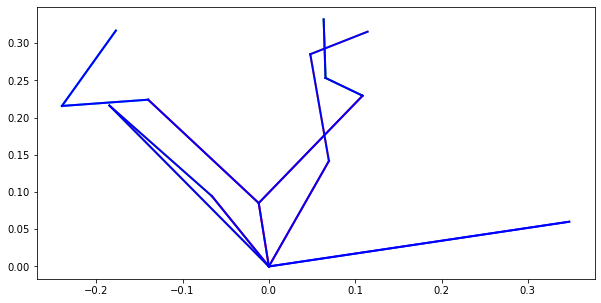

In [4]:
from liftpose.preprocess import anchor_to_root, pose_norm
from liftpose.plot import plot_pose_3d, plot_pose_2d
from liftpose.vision_3d import world_to_camera, project_to_camera
import matplotlib.pyplot as plt

ptssh = train_2d[30,:,:]
pts3d_proj = train_3d[30,:,:]

fig = plt.figure(figsize=(10,5))
ax_2d = fig.add_subplot(111)

target_sets = par_data['data']['target_sets']
roots = par_data['data']['roots']

pts3d_proj = world_to_camera(pts3d_proj[None,:], cams['R'][0], cams['tvec'][0] )
pts3d_proj = project_to_camera(pts3d_proj,cams['intr'][0])

#anchor
pts3d_proj = {'pts3d_proj': pts3d_proj.flatten()[None,:]}
ptssh = {'ptssh': ptssh.flatten()[None,:]}

ptssh, _ = anchor_to_root(ptssh, roots, target_sets, 2)
pts3d_proj, _ = anchor_to_root(pts3d_proj, roots, target_sets, 2)

pts3d_proj = pose_norm(pts3d_proj)
ptssh = pose_norm(ptssh)

pts3d_proj = pts3d_proj['pts3d_proj']
ptssh = ptssh['ptssh']

pts3d_proj = pts3d_proj.reshape(pts3d_proj.size//2,2)
ptssh = ptssh.reshape(ptssh.size//2,2)

plot_pose_2d(ax_2d, ptssh, normalize=False, bones=par_data["vis"]["bones"], limb_id=par_data["vis"]["limb_id"], colors=par_data["vis"]["colors"])
plot_pose_2d(ax_2d, pts3d_proj, normalize=False, bones=par_data["vis"]["bones"], limb_id=par_data["vis"]["limb_id"])
             


In [ ]:
from liftpose.plot import plot_pose_3d
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-75, azim=-90)
t = 1000
pose = test_3d[t][None,:,:]
pred = normalize_bone_length(pose.copy(), 
                             root=par["roots"][0], 
                             child=par_data["vis"]["child"], 
                             bone_length=bone_length, 
                             thr=1)
plot_pose_3d(ax=ax, 
             tar=pose[0],
             pred = pred[0],
             normalize=False, 
             bones=par_data["vis"]["bones"], 
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"])

In [ ]:
bone_len = calculate_bone_length(test_3d, par_data['vis']['bones'])
avg_bone_len= np.nanmean(bone_len, axis=0)
std_bone_len= np.nanstd(bone_len, axis=0)

In [ ]:
from scipy.spatial.transform import Rotation as R
for c in cams['R']:
    r = R.from_matrix(c).as_euler('zyx', degrees=True)
    print(r)

for c in cams['tvec']: 
    print(c)
    
for c in cams['intr']: 
    print(c)

In [5]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import random_project, perturb_pose
from liftpose.vision_3d import intrinsic_matrix

training_kwargs = {'eangles': {0: [[4,5], [2, 3], [92.5,93.5]],
                               1: [[-22,-21], [1,2], [97.5,98.5]]},
                   'axsorder': 'zyx',
                   'vis': None,
                   'tvec': None,
                   'intr': None}
                  


#training_kwargs = {'perturb': 1,
#                   'child': par_data["vis"]["child"],
#                   'bones': par_data['vis']['bones'],
#                   'avg_bone_len': avg_bone_len,
#                   'std_bone_len': std_bone_len}

#aug = perturb_pose(**training_kwargs)
aug = random_project(**training_kwargs)

lp3d_train(train_2d={'train':train_2d}, test_2d={'test':test_2d},
           train_3d={'train':train_3d}, test_3d={'test':test_3d},
           train_keypts={'train':train_keypoints}, test_keypts={'test':test_keypoints}, 
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'], 
           training_kwargs={"epochs":10},
           augmentation=[aug],
           stats=None)

[main.py:250]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/capture/out_across_animals/stat_2d.pth.tar.


/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/preprocess.py:198: RuntimeWarning: invalid value encountered in true_divide
  tmp /= np.linalg.norm(tmp, ord='fro', axis=(1,2), keepdims=True)
/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/preprocess.py:148: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(cp_d, axis=0)
/home/gosztolai/anaconda3/envs/LiftPose3D/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[main.py:269]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/capture/out_across_animals/stat_3d.pth.tar.
[main.py:297]:INFO:Starting training model.
[main.py:307]:DEBUG:
==================Options=================
[main.py:308]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/capture/out_across_animals',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/capture/out_across_animals',
    'out_dir': '/data/LiftPose3D/capture/out_across_animals',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:309]:DEBUG:==========================================

[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:53]:INFO:total params: 4.28M


Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  0.23503|: 100%|██████████| 844/844 [00:06<00:00, 133.74it/s]
Epoch 001 | LR  0.00100 | Loss Test  0.07603 | Loss Train  0.06365|: 100%|██████████| 844/844 [00:06<00:00, 136.58it/s]
Epoch 002 | LR  0.00100 | Loss Test  0.07354 | Loss Train  0.05677|: 100%|██████████| 844/844 [00:06<00:00, 136.93it/s]
Epoch 003 | LR  0.00100 | Loss Test  0.07706 | Loss Train  0.05435|: 100%|██████████| 844/844 [00:06<00:00, 135.19it/s]
Epoch 004 | LR  0.00100 | Loss Test  0.07171 | Loss Train  0.05369|: 100%|██████████| 844/844 [00:06<00:00, 135.25it/s]
Epoch 005 | LR  0.00090 | Loss Test  0.07396 | Loss Train  0.05198|: 100%|██████████| 844/844 [00:06<00:00, 134.16it/s]
Epoch 006 | LR  0.00090 | Loss Test  0.07042 | Loss Train  0.04942|: 100%|██████████| 844/844 [00:06<00:00, 138.15it/s]
Epoch 007 | LR  0.00090 | Loss Test  0.07324 | Loss Train  0.04691|: 100%|██████████| 844/844 [00:06<00:00, 134.68it/s]
Epoch 008 | LR  0.00090 | Loss Test  0.0

In [ ]:
from liftpose.preprocess import obtain_projected_stats
from liftpose.vision_3d import intrinsic_matrix

training_kwargs = {'eangles': {0: [[4,5], [2, 3], [92.5,93.5]], 
                               1: [[61,62], [-2, -1], [105,106]],
                               2: [[178,179], [1,2], [95, 96]],
                               3: [[-26,-25], [-6,-5], [122,123]],
                               4: [[-86,-85], [3,4], [99,100]],
                               5: [[-162,-161], [3.5,4.5], [122,123]],
                               6: [[-22,-21], [1,2], [97.5,98.5]], 
                               7: [[25,26], [-6,-5], [106,107]],
                               8: [[177,178], [1.5,2.5], [96,97]],
                               9: [[-62.5,-61.5],[7.5,8.5],[127,128]],
                               10: [[-91,-90],[5,6],[98.5,99.5]],
                               11: [[-167.5,-166.5], [3,4], [123,124]]
                              },
                   'axsorder': 'zyx',
                   'vis': None,
                   'tvec': {0: [ -33.9455647 ,  184.49834808, 2089.10360588],
                            1: [ 143.4930137 ,   -2.43526674, 1094.73951846],
                            2: [ -10.72773212,  159.9681786 , 1540.27764687],
                            3: [ -78.22016597,  -47.31990592, 1896.98785563],
                            4: [ -59.44927817,  119.76429314, 1272.46901284],
                            5: [-143.39515499,  -29.4669944 , 2041.4269706 ],
                            6: [  52.15635248,   14.78589254, 1652.57736187],
                            7: [ 185.09405015, -202.25953714, 1458.57970915],
                            8: [ -61.33219824,  208.35834662, 1410.94696213],
                            9: [-454.32898822,  225.74632549, 1507.65379937],
                            10: [ -30.31844848,  109.41125686, 1232.03125439],
                            11: [ -44.51723575,   71.81739837, 2134.53624422]
                           },
                   'intr': {0: intrinsic_matrix(4.07641979e+03, 4.07125474e+03, 7.12608040e+02, 5.21258792e+02),  
                            1: intrinsic_matrix(2.00744532e+03, 2.00909500e+03, 4.00904122e+02, 8.25726056e+02),
                            2: intrinsic_matrix(2.85174016e+03, 2.83808496e+03, 7.11022140e+02, 5.24518247e+02),
                            3: intrinsic_matrix(3.79347539e+03, 3.76916825e+03, 8.11293797e+02, 7.02807447e+02),
                            4: intrinsic_matrix(2.43888987e+03, 2.45279112e+03, 7.69305140e+02, 5.07054152e+02),
                            5: intrinsic_matrix(3.41258593e+03, 3.40076337e+03, 9.18920974e+02, 7.04645797e+02),
                            6: intrinsic_matrix(3.13815209e+03, 3.14222877e+03, 5.83523022e+02, 8.19950713e+02),
                            7: intrinsic_matrix(3.12559945e+03, 3.09828758e+03, 2.84766026e+02, 1.30580228e+03),
                            8: intrinsic_matrix(2.58173661e+03, 2.55273142e+03, 8.21929910e+02, 4.30284806e+02),
                            9: intrinsic_matrix(2.16988275e+03, 2.18797410e+03, 1.18626816e+03, 3.27033298e+02),
                            10: intrinsic_matrix(2.35926817e+03, 2.35708969e+03, 7.08833499e+02, 5.17465673e+02),
                            11: intrinsic_matrix(3.56592146e+03, 3.55880309e+03, 7.61598222e+02, 5.23943855e+02)
                           }
                  }

#stats = obtain_projected_stats({'train_3d':train_3d},
#                               training_kwargs['eangles'], 
#                               training_kwargs['axsorder'], 
#                               training_kwargs['vis'],
#                               training_kwargs['tvec'],
#                               training_kwargs['intr'],
#                               par['roots'], 
#                               par['target_sets'],
#                               par['out_dir'],
#                               load_existing=True,
#                               th=10)

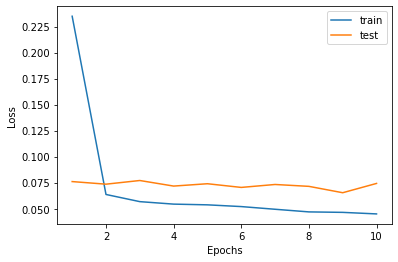

In [7]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

In [8]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:397]:INFO:starting testing in path: /data/LiftPose3D/capture/out_across_animals
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:53]:INFO:total params: 4.28M
[lift.py:61]:INFO:loading ckpt from '/data/LiftPose3D/capture/out_across_animals/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 9 | err: 2.2179901052499997)
[lift.py:103]:INFO:Saving results: /data/LiftPose3D/capture/out_across_animals/test_results.pth.tar


In [9]:
from liftpose.postprocess import load_test_results
from liftpose.vision_3d import camera_to_world

out_dir = par['out_dir']
#out_dir = '/data/LiftPose3D/capture/out_across_animals'

data = torch.load(os.path.join(out_dir, "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(out_dir, "stat_2d.pth.tar")),
    torch.load(os.path.join(out_dir, "stat_3d.pth.tar")),
)

#assert len(test_cam_id) == 1
cam = read_cam(session_id, test_cam_id[0])
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

s = test_3d_gt.shape
test_3d_gt = camera_to_world(test_3d_gt.reshape(s[0], -1), cam['r'].T, cam['t']).reshape(s)
test_3d_pred = camera_to_world(test_3d_pred.reshape(s[0],-1), cam['r'].T, cam['t']).reshape(s)
#test_3d_pred[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan
test_3d_gt[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan

array([[   70.63786608, -1975.30346941,   406.03682315],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [   82.12857306, -1972.16242033,   318.67879716],
       [           nan,            nan,            nan],
       [   91.30727039, -2022.72701824,   252.48136287],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [  111.62508119, -2040.55863686,   257.41003505],
       [   67.30932807, -2044.12205275,   268.17999102],
       [   68.17623649, -2020.87393192,   335.83141942],
       [   78.30548632, -2026.0269072 ,   355.32726152],
       [  106.05392825, -1981.00428673,   331.71177455],
       [   67.37897987, -1984.08027206,   323.59438499],
       [   67.00970498, -2019.81966224,   333.21810103],
       [   75.81609071, -2016.99650786,   353.20857234],
       [   63.92833322, -2032.49891176,   286.43076593],
       [  123.45804435, -2033.5

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[nan nan nan]


/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/plot.py:94: RuntimeWarning: Mean of empty slice
  pts = np.nanmean(tar, axis=0)


ValueError: Axis limits cannot be NaN or Inf

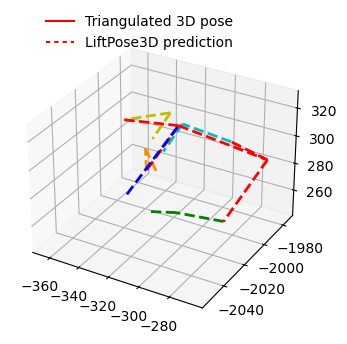

In [25]:
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d
%matplotlib widget
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
i=100
plot_pose_3d(ax=ax, tar=test_3d_gt[i],
             pred=test_3d_pred[i],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"], 
            normalize=False, show_pred_always=True)      

origin = test_3d_gt[i][3]
print(origin)
ax.set_xlim(origin[0]-100, origin[0]+100)
ax.set_ylim(origin[1]-100, origin[1]+100)
ax.set_zlim(-100,25)

In [ ]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
from celluloid import Camera
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

c = 0
for i in range(test_3d_gt.shape[0]):
    plot_pose_3d(ax=ax, tar=test_3d_gt[i],
                 pred=test_3d_pred[i],
                bones=par_data["vis"]["bones"], 
                limb_id=par_data["vis"]["limb_id"], 
                colors=par_data["vis"]["colors"], 
                normalize=False)
    origin = test_3d_gt[i][3]
    try:
        ax.set_xlim(origin[0]-100, origin[0]+100)
        ax.set_ylim(origin[1]-100, origin[1]+100)
        ax.set_zlim(-100,25)
        plt.savefig(f'out/pred{c}_missing.jpg')
        c += 1
    except:
        ax.clear()
        continue
    #camera.snap()
    ax.clear()

In [ ]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
#%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

t = 50
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"],
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False)

In [ ]:
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.set_aspect('equal')
#ax.set_box_aspect([1,1,1])
#ax.view_init(elev=200, azim=60)
mat = read_data(0, 3)
pts3d = mat['data_3d'].reshape(-1,20,3)

plot_pose_3d(ax=ax, tar=pts3d[700],
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"], 
        colors=par_data["vis"]["colors"], 
        normalize=True)        

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
from celluloid import Camera


#ax.view_init(elev=200, azim=60)

camera = Camera(fig)
for t in range(0, 100):
    plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False)
    camera.snap()
camera.animate().save('test.mp4')

In [ ]:
from IPython.display import Video
Video("test.mp4")

# Plot 2D

In [ ]:
mat

In [ ]:
frame_id = 1141
idx = np.where(mat[0]['data_sampleID'] == frame_id)[0][0]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(nrows=2, ncols=3, dpi=100, figsize=(20,10))
axs = np.ravel(np.array(axs))
for cam_id, ax in enumerate(axs):
    ax.imshow(plt.imread(f'images/sample0_{frame_id}_Camera{cam_list[cam_id]}.png'))
    pt = mat[cam_id]['data_2d'][idx].reshape(-1,2)
    ax.scatter(pt[:,0]-20, pt[:,1], c=marker_color[:20], s=5)
    ax.axis('off')

In [ ]:
%matplotlib widget
par_data = yaml.full_load(open('param.yaml', "rb"))
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

ax.view_init(20,40)
i = 100
pts3d = mat[3]['data_3d'][i].reshape(-1,3)

for k in np.where(np.isnan(pts3d))[0]:
    pts3d[k] = pts3d[k-1]

plot_pose_3d(ax=ax, tar=pts3d,
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"], 
        colors=par_data["vis"]["colors"],
            normalize=False)

# Check original dataset data

In [ ]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
from celluloid import Camera
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.set_aspect('equal')
#ax.set_box_aspect([1,1,1])
#ax.view_init(elev=200, azim=60)
mat = read_data(0, 3)
camera = Camera(fig)

pts3d = mat['data_3d'].reshape(-1,20,3)[400:500]

for i in range(pts3d.shape[0]):
    plot_pose_3d(ax=ax, tar=pts3d[i],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"], 
            normalize=False, show_pred_always=True)        
    camera.snap()
    #ax.clear()

camera.animate().save('test2.mp4')

In [ ]:
from IPython.display import Video
Video("test2.mp4")

In [ ]:
plt.title('Percentage of missing 3D points per joint')
plt.scatter(np.arange(20), np.sum(np.isnan(mat[5]['data_3d'].reshape(-1,20,3)),axis=(0,2))/3/mat[5]['data_3d'].shape[0] * 100)
plt.gca().set_xticks(range(20))
plt.gca().set_xticklabels([_[0] for _ in meta['markernames']], rotation='vertical', fontsize=18)
plt.ylabel('Percentage')

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

joints_name = par_data['vis']['names']
err_norm = np.sum(np.abs((test_3d_gt - test_3d_pred).reshape(test_3d_gt.shape[0], 20, 3)), axis=-1)
err_norm_sp = err_norm.copy()
joints_list = list()
    
for j in range(20):
    q = np.quantile(err_norm[:,j], 0.90)
    err_norm_sp[err_norm_sp[:,j] > q, j] = q

e_list = list()
n_list = list()
for i in range(err_norm_sp.shape[0]):
    for j in range(err_norm_sp.shape[1]):
        if not np.isnan(err_norm_sp[i,j]):
            if test_keypoints[i,j,0]:
                e_list.append(err_norm_sp[i,j] / 263.67092825261545 * 100)
                n_list.append(joints_name[j][0])

d = pd.DataFrame({"err":e_list, "joint": n_list})

q = d.quantile(q=0.95)
d = d.loc[d['err'] < q['err']]

plt.figure(dpi=300, figsize=(10,5))
plt.grid(False)
s = sns.violinplot(x="joint" , y="err", data=d, color='gray', order=order)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.xlabel('')
plt.ylabel('Percentage of body length')
plt.ylim([0,15])
plt.savefig('errors.png')

In [ ]:
order = ['HeadF',
         'HeadB',
         'HeadL',
         'SpineM',
         'SpineL',
         'HipL',
         'HipR',
         'ElbowL',
         'ArmL',
         'ShoulderL',
         'ShoulderR',
         'ElbowR',
         'ArmR',
         'KneeR',
         'KneeL',
         'ShinL',
         'ShinR']